In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py, glob
import pandas as pd

from collections import defaultdictcond
from random import choices
from scipy.interpolate import interp1d
from scipy.stats import kstest
from scipy.stats import ks_2samp
from ang_res_funcs import *

In [2]:
PARENT_DIRECTORY = '/data/ana/CosmicRay/Anisotropy/IceTop/twelve_year/03_sim_study'
#DIRECTS = [f'{PARENT_DIRECTORY}/IT81-2012_orig', f'{PARENT_DIRECTORY}/IT81-2012', f'{PARENT_DIRECTORY}/IT81-2015', f'{PARENT_DIRECTORY}/IT81-2018']
COLORS = ['green', 'blue', 'red']
LABELS = ['2012', '2015', '2018']

In [ ]:
# Histogram storage and setup
energy_hist = defaultdict(lambda: defaultdict(np.array))
density_hist = defaultdict(lambda: defaultdict(np.array))
weighted_uncertainty = defaultdict(lambda: defaultdict(np.array))
relative_weights = defaultdict(lambda: defaultdict(np.array))

# Bins and scale designed for display in PeV
bins = 10**(np.arange(-1,2,.1))
bin_centers = (bins[:-1] + bins[1:]) / 2
scale = 10**-6

for TIER in [3,4]:
    
    for YEAR in YEARS:

        energies = []
        weights = []

        # Populate energies and weights
        for COMP in ['Proton','Helium','Oxygen','Iron']:
            energies += list(np.load(f'{PARENT_DIRECTORY}/IT81-{YEAR}/{COMP}-T{TIER}-MC-Energy.npy'))
            weights += list(np.load(f'{PARENT_DIRECTORY}/IT81-{YEAR}/{COMP}-T{TIER}-MC-Weights.npy'))

        # Scale energies and normalize weights
        energies = np.asarray(energies) * scale
        #weights = np.asarray(weights) / np.sum(weights)
        weights = np.asarray(weights)
        
        energy_hist[TIER][YEAR] = np.histogram(energies, bins=bins, weights=weights)[0]
        weighted_uncertainty[TIER][YEAR] = np.sqrt(np.histogram(energies, bins=bins, weights=weights**2)[0])
        density_hist[TIER][YEAR] = np.histogram(energies, bins=bins, weights=weights, density=True)[0]
        # Fancier division function for relative weights takes care of 0's in divisor
        relative_weights[TIER][YEAR] = np.divide(weighted_uncertainty[TIER][YEAR], energy_hist[TIER][YEAR], 
                                                 out=np.zeros_like(weighted_uncertainty[TIER][YEAR]), 
                                                 where=energy_hist[TIER][YEAR]!=0)

In [ ]:
# Initialize histogram array
histograms = plt.figure(figsize=(16, 10), constrained_layout=True)
hist_array = histograms.subplots(2, 2, squeeze=False)

for row, h_i in enumerate(hist_array):
    for col, ax in enumerate(h_i):
        
        TIER = 3 if col==0 else 4
        
        # Normalized histograms of energy distributions in first row
        if row == 0:
            for i, YEAR in enumerate(YEARS):
                ax.step(bin_centers, energy_hist[TIER][YEAR], where='mid', color=COLORS[i], label=YEAR)
                ax.errorbar(bin_centers, energy_hist[TIER][YEAR], yerr=weighted_uncertainty[TIER][YEAR], fmt='o', color=COLORS[i])
                ax.step(bin_centers, density_hist[TIER][YEAR], where='mid', color=COLORS[i], label=f'{YEAR}_dense', linestyle='dashed')
                ax.errorbar(bin_centers, density_hist[TIER][YEAR], yerr=relative_weights[TIER][YEAR]*density_hist[TIER][YEAR], fmt='o', color=COLORS[i])
            ylabel = 'Fraction of Events'
        
        # PDFs in second row
        elif row == 1:
            for i, YEAR in enumerate(YEARS):
                interp_function = interp1d(bin_centers, density_hist[TIER][YEAR], kind='cubic', fill_value='extrapolate')
                x = np.linspace(bins[0], bins[-1], 1000)       
                y = interp_function(x)
                ax.plot(x, y, label=YEAR, color=COLORS[i])
            ylabel = 'Probability'
        
        ax.set_title(f'Tier {TIER}')
        ax.semilogx()
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Energy (E/PeV)')
        ax.legend()

plt.show()

In [ ]:
for TIER in [3,4]:
    
    print(f'Tier {TIER}:')
    pdf_2012 = interp1d(bin_centers, density_hist[TIER]['2012'], kind='cubic', fill_value='extrapolate')
    
    for YEAR in YEARS:
        
        def inverse_transform_sampling(size=100):
            cum_values = np.zeros(bins.shape)
            cum_values[1:] = np.cumsum(density_hist[TIER][YEAR] * np.diff(bins))
            inv_cdf = interp1d(cum_values, bins)
            r = np.random.rand(size)
            return inv_cdf(r)

        ks_stat, p_value = kstest(inverse_transform_sampling, lambda x: pdf_2012(x))
        print(f'  2012 and {YEAR}: p-value = {p_value}')


In [ ]:
# Create residual plots
histograms = plt.figure(figsize=(16, 5), constrained_layout=True)
hist_array = histograms.subplots(1, 2, squeeze=False)

for row, h_i in enumerate(hist_array):
    for col, ax in enumerate(h_i):
        
        TIER = 3 if col==0 else 4
        
        ax.step(bin_centers, density_hist[TIER]['2015'] - density_hist[TIER]['2012'], where='mid', color=COLORS[0], label='2015 - 2012')
        ax.step(bin_centers, density_hist[TIER]['2018'] - density_hist[TIER]['2012'], where='mid', color=COLORS[1], label='2018 - 2012')
        ylabel = 'Residual Fraction of Events'
        
        ax.set_title(f'Tier {TIER}')
        ax.semilogx()
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Energy (E/PeV)')
        ax.legend()

plt.show()

In [ ]:
# Create residual plots
histograms = plt.figure(figsize=(16, 5), constrained_layout=True)
hist_array = histograms.subplots(1, 2, squeeze=False)

y_upper_limit = 100
for row, h_i in enumerate(hist_array):
    for col, ax in enumerate(h_i):
        
        TIER = 3 if col==0 else 4
        
        ax.step(bin_centers, (density_hist[TIER]['2015'] - density_hist[TIER]['2012']) * 100 / density_hist[TIER]['2012'], where='mid', color=COLORS[0], label='2015 - 2012')
        ax.step(bin_centers, (density_hist[TIER]['2018'] - density_hist[TIER]['2012']) * 100 / density_hist[TIER]['2012'], where='mid', color=COLORS[1], label='2018 - 2012')
        ylabel = 'Percent Difference'
        
        ax.set_title(f'Tier {TIER}')
        ax.semilogx()
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Energy (E/PeV)')
        ax.legend()
        ax.set_ylim(top=y_upper_limit)

plt.show()

In [ ]:
#OLD

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.30261450e-04 1.89625740e-04 3.41415707e-04 4.91467479e-04
 6.88497661e-04 7.93979268e-04 1.83164746e-03 1.80862881e-03
 1.67953117e-03 1.39023627e-03 1.07445558e-03 7.71307002e-04
 5.19650108e-04 3.39801620e-04 2.19934661e-04 1.38049939e-04
 1.16580238e-04 7.49240998e-05 4.85602313e-05 3.11945957e-05
 2.04978890e-05 1.35253841e-05 8.64555903e-06 5.59040937e-06
 3.58572067e-06]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.03441807e-04 2.96156717e-04 5.33221674e-04 7.67571928e-04
 1.07529287e-03 1.24003362e-03 1.76601946e-03 1.74382557e-03
 1.61935350e-03 1.34042405e-03 1.03595779e-03 7.43671041e-04
 5.01031024e-04 3.27858496e-04 2.12054394e-04 1.33103604e-04
 1.31746380e-04 8.46711167e-05 5.48775230e-05 3.52422527e-05
 2.31809467e-05 1.52849268e-05 9.77027604e-06 6.31767623e-06
 4.05493302e-06]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.60864496e-04 6.749

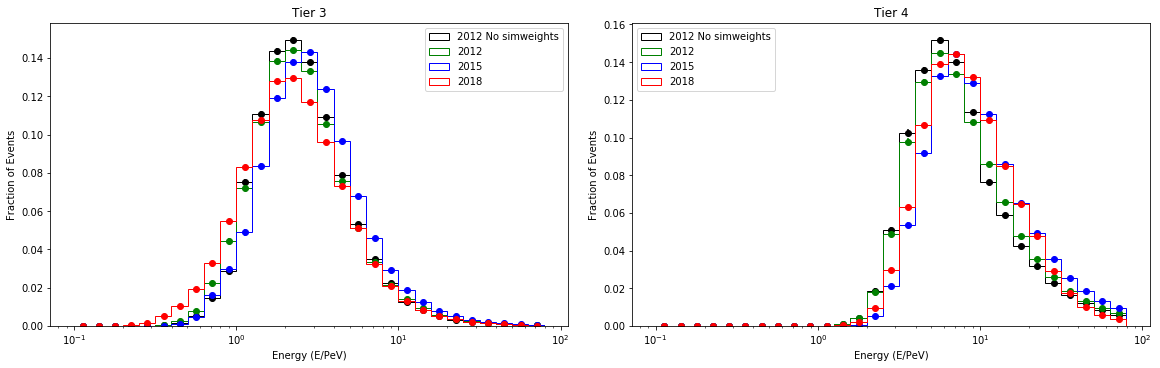

KS Test Results for Tier 3:
Between 2012 No simweights and 2012: p-value = 0.9999999821443393
Between 2012 No simweights and 2015: p-value = 0.9999999821443393
Between 2012 No simweights and 2018: p-value = 0.9984782925008956
Between 2012 and 2015: p-value = 0.9999999821443393
Between 2012 and 2018: p-value = 0.9984782925008956
Between 2015 and 2018: p-value = 0.9514369595559768

KS Test Results for Tier 4:
Between 2012 No simweights and 2012: p-value = 0.9999999821443393
Between 2012 No simweights and 2015: p-value = 0.9999999821443393
Between 2012 No simweights and 2018: p-value = 0.9999999821443393
Between 2012 and 2015: p-value = 0.9999999821443393
Between 2012 and 2018: p-value = 0.9999999821443393
Between 2015 and 2018: p-value = 0.9999999821443393


In [3]:
histograms = plt.figure(figsize=(16, 5), constrained_layout=True)
hist_array = histograms.subplots(1, 2, squeeze=False)

hist_array[0,0].set_title('Tier 3')
hist_array[0,0].semilogx()
hist_array[0,0].set_ylabel('Fraction of Events')
hist_array[0,0].set_xlabel('Energy (E/PeV)')

hist_array[0,1].set_title('Tier 4')
hist_array[0,1].semilogx()
hist_array[0,1].set_ylabel('Fraction of Events')
hist_array[0,1].set_xlabel('Energy (E/PeV)')

# Initialize lists to store data for KS test
all_hist_t3 = []
all_hist_t4 = []

for i, DIRECT in enumerate(DIRECTS):       
    mc_en_p_t3 = np.load(DIRECT +'/Proton-T3-MC-Energy.npy')
    mc_en_he_t3 = np.load(DIRECT +'/Helium-T3-MC-Energy.npy')
    mc_en_o_t3 = np.load(DIRECT +'/Oxygen-T3-MC-Energy.npy')
    mc_en_fe_t3 = np.load(DIRECT +'/Iron-T3-MC-Energy.npy')
    
    mc_en_p_t4 = np.load(DIRECT +'/Proton-T4-MC-Energy.npy')
    mc_en_he_t4 = np.load(DIRECT +'/Helium-T4-MC-Energy.npy')
    mc_en_o_t4 = np.load(DIRECT +'/Oxygen-T4-MC-Energy.npy')
    mc_en_fe_t4 = np.load(DIRECT +'/Iron-T4-MC-Energy.npy')
    
    mc_w_p_t3 = np.load(DIRECT +'/Proton-T3-MC-Weights.npy')
    mc_w_he_t3 = np.load(DIRECT +'/Helium-T3-MC-Weights.npy')
    mc_w_o_t3 = np.load(DIRECT +'/Oxygen-T3-MC-Weights.npy')
    mc_w_fe_t3 = np.load(DIRECT +'/Iron-T3-MC-Weights.npy')
    
    mc_w_p_t4 = np.load(DIRECT +'/Proton-T4-MC-Weights.npy')
    mc_w_he_t4 = np.load(DIRECT +'/Helium-T4-MC-Weights.npy')
    mc_w_o_t4 = np.load(DIRECT +'/Oxygen-T4-MC-Weights.npy')
    mc_w_fe_t4 = np.load(DIRECT +'/Iron-T4-MC-Weights.npy')
    
    mc_en_t3 = np.concatenate((mc_en_p_t3, mc_en_he_t3, mc_en_o_t3, mc_en_fe_t3), axis=None)
    mc_en_t4 = np.concatenate((mc_en_p_t4, mc_en_he_t4, mc_en_o_t4, mc_en_fe_t4), axis=None)
    
    mc_w_t3 = np.concatenate((mc_w_p_t3, mc_w_he_t3, mc_w_o_t3, mc_w_fe_t3), axis=None)
    mc_w_t4 = np.concatenate((mc_w_p_t4, mc_w_he_t4, mc_w_o_t4, mc_w_fe_t4), axis=None)

    bins = 10**(np.arange(-1,2,.1))
    scale = 10**-6
    
    hist_t3, bin_edges_t3 = np.histogram(mc_en_t3 * scale, bins=bins, weights=mc_w_t3 / sum(mc_w_t3))
    bin_centers_t3 = (bin_edges_t3[:-1] + bin_edges_t3[1:]) / 2
    all_hist_t3.append(hist_t3)

    weighted_uncertainty_t3 = np.sqrt(np.histogram(mc_en_t3 * scale, bins=bins, weights=(mc_w_t3 / sum(mc_w_t3))**2)[0])

    print(weighted_uncertainty_t3)
    
    hist_array[0,0].hist(mc_en_t3*scale, bins, weights=mc_w_t3/sum(mc_w_t3), histtype="step", linestyle="solid", color=COLORS[i], label=LABELS[i])
    hist_array[0, 0].errorbar(bin_centers_t3, hist_t3, yerr=weighted_uncertainty_t3, fmt='o', color=COLORS[i])      
    hist_array[0,0].legend(loc='upper right')

    hist_t4, bin_edges_t4 = np.histogram(mc_en_t4 * scale, bins=bins, weights=mc_w_t4 / sum(mc_w_t4))    
    bin_centers_t4 = (bin_edges_t4[:-1] + bin_edges_t4[1:]) / 2
    all_hist_t4.append(hist_t4)

    weighted_uncertainty_t4 = np.sqrt(np.histogram(mc_en_t4*scale, bins=bins, weights=(mc_w_t4 / sum(mc_w_t4))**2)[0])
    
    hist_array[0,1].hist(mc_en_t4*scale, bins, weights=mc_w_t4/sum(mc_w_t4), histtype="step", linestyle="solid", color=COLORS[i], label=LABELS[i])
    hist_array[0, 1].errorbar(bin_centers_t4, hist_t4, yerr=weighted_uncertainty_t4, fmt='o', color=COLORS[i])      
    hist_array[0,1].legend(loc='upper left')
    
    if i == len(DIRECTS) - 1:
        plt.show()

# KS test for Tier 3
print("KS Test Results for Tier 3:")
for i in range(len(DIRECTS)):
    for j in range(i + 1, len(DIRECTS)):
        ks_stat, p_value = ks_2samp(all_hist_t3[i], all_hist_t3[j])
        print(f"Between {LABELS[i]} and {LABELS[j]}: p-value = {p_value}")

print()

# KS test for Tier 4
print("KS Test Results for Tier 4:")
for i in range(len(DIRECTS)):
    for j in range(i + 1, len(DIRECTS)):
        ks_stat, p_value = ks_2samp(all_hist_t4[i], all_hist_t4[j])
        print(f"Between {LABELS[i]} and {LABELS[j]}: p-value = {p_value}")
